In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import roc_curve, auc

Part1:

In [2]:
df = pd.read_csv("cybersecurity_intrusion_data.csv")
print(df.shape)
sample_df = df.sample(n=1000, random_state=1)
sample_df.to_csv("sample_predict_data.csv", index=False)
df.head()

(9537, 11)


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


In [4]:
df.isnull().sum()

session_id                0
network_packet_size       0
protocol_type             0
login_attempts            0
session_duration          0
encryption_used        1966
ip_reputation_score       0
failed_logins             0
browser_type              0
unusual_time_access       0
attack_detected           0
dtype: int64

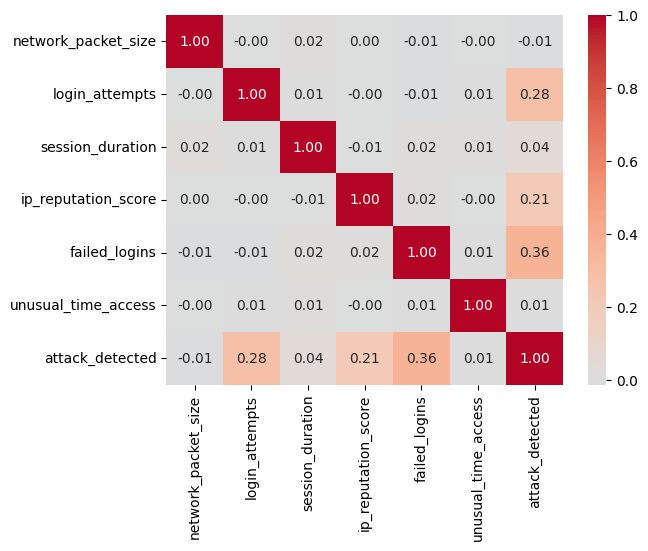

In [5]:
sns.heatmap(df.select_dtypes(include=["number"]).corr(), cmap="coolwarm", center=0, annot=True, fmt=".2f");

From the correlation heatmap, all numerical features show very low linear correlation with the attack label, indicating that attack behavior is not determined by simple linear relationships.

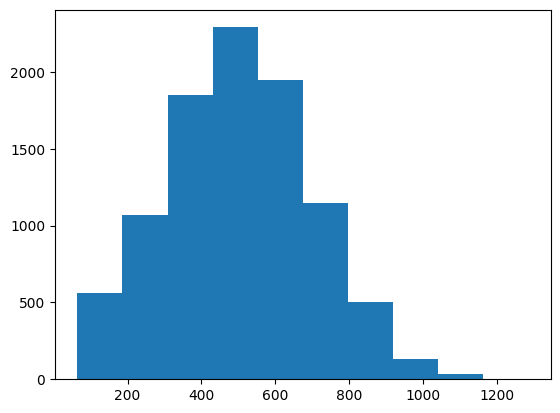

In [6]:
plt.hist(df.network_packet_size);

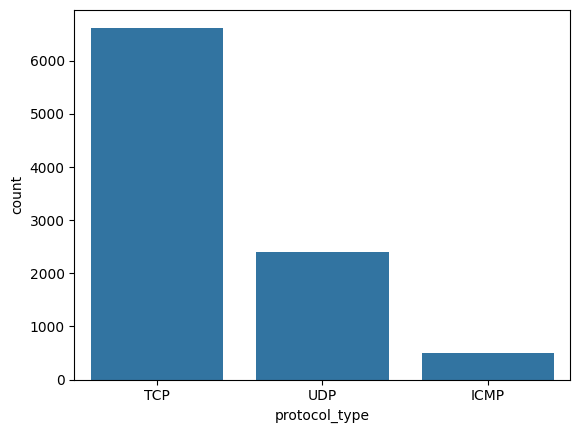

In [7]:
sns.countplot(x = "protocol_type", data = df);

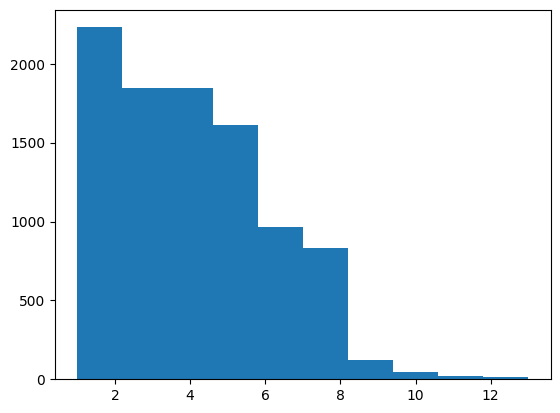

In [8]:
plt.hist(df.login_attempts);

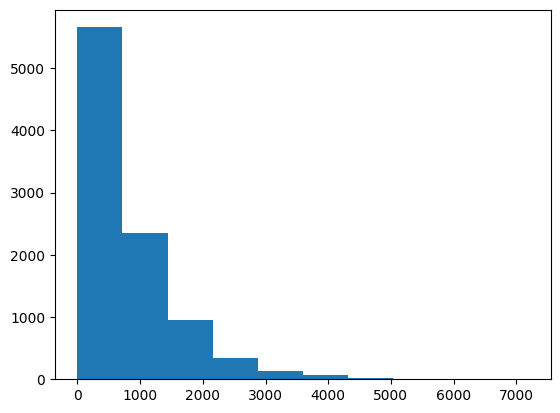

In [9]:
plt.hist(df.session_duration);

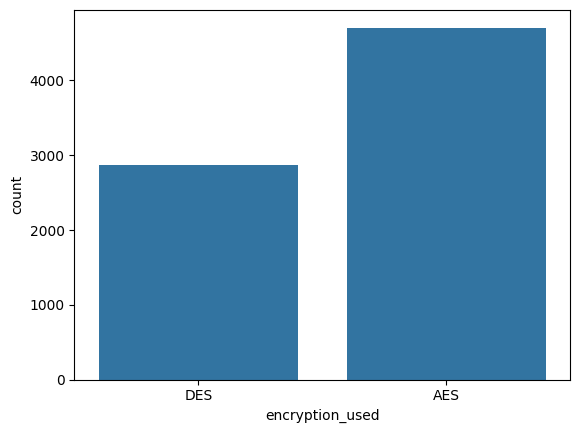

In [10]:
sns.countplot(x = "encryption_used", data = df);

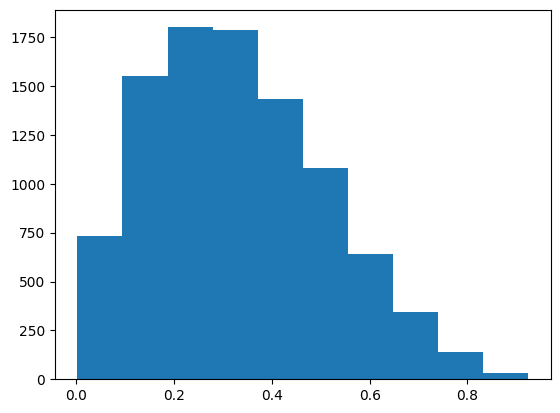

In [11]:
plt.hist(df.ip_reputation_score);

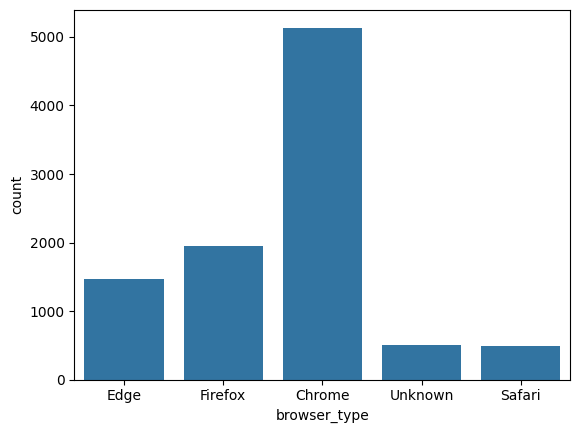

In [12]:
sns.countplot(x = "browser_type", data = df);

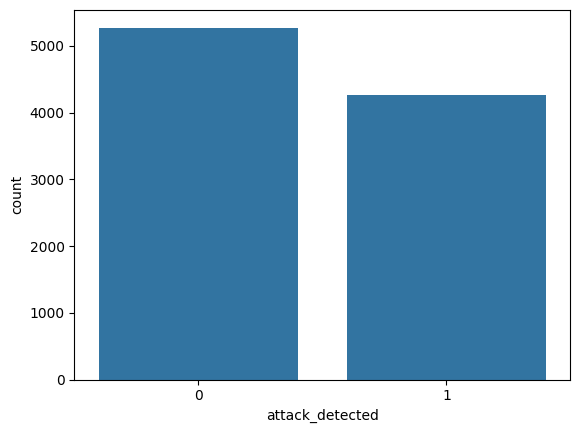

In [13]:
sns.countplot(x = "attack_detected", data = df);

The number of normal and attack samples is slightly imbalanced

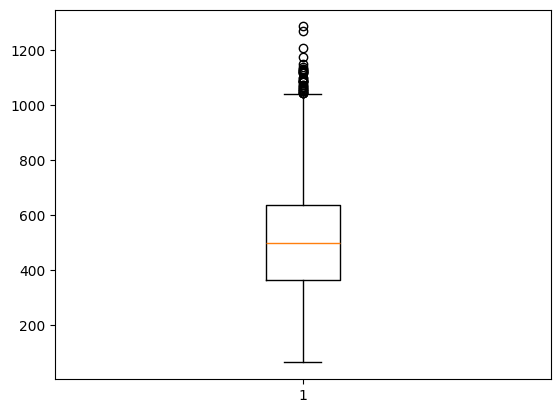

In [14]:
plt.boxplot(df.network_packet_size);

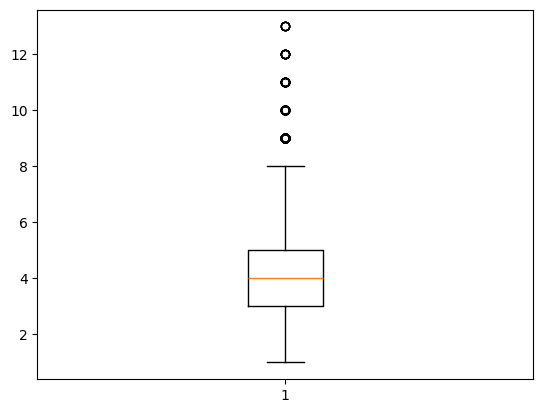

In [15]:
plt.boxplot(df.login_attempts);

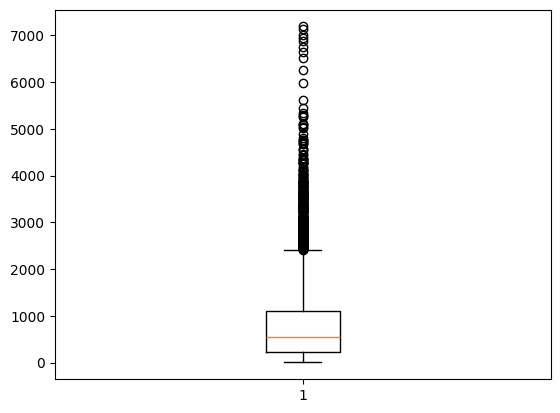

In [16]:
plt.boxplot(df.session_duration);

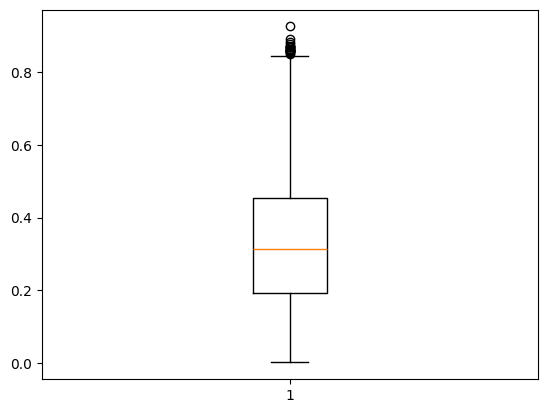

In [17]:
plt.boxplot(df.ip_reputation_score);

Some features contain many outliers and show strong right-skewed distributions. I chose to keep these values, these extreme behaviors could be important indicators of attacks

In [18]:
protocol_map = {"TCP": 0,"UDP": 1,"ICMP": 2}
encryption_map = {"DES": 0,"AES": 1,"NoEncryption": 2}
browser_map = {"Edge": 0,"Firefox": 1,"Chrome": 2,"Safari": 3,"Unknown": 4}
df['encryption_used'] = df['encryption_used'].fillna("NoEncryption")
df["protocol_type"] = df["protocol_type"].map(protocol_map)
df["encryption_used"] = df["encryption_used"].map(encryption_map)
df["browser_type"] = df["browser_type"].map(browser_map)
df = df.drop(columns=["session_id"])
df.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,599,0,4,492.983263,0,0.606818,1,0,0,1
1,472,0,3,1557.996461,0,0.301569,0,1,0,0
2,629,0,3,75.044262,0,0.739164,2,2,0,1
3,804,1,4,601.248835,0,0.123267,0,4,0,1
4,453,0,5,532.540888,1,0.054874,1,1,0,0


In [19]:
df.isnull().sum()

network_packet_size    0
protocol_type          0
login_attempts         0
session_duration       0
encryption_used        0
ip_reputation_score    0
failed_logins          0
browser_type           0
unusual_time_access    0
attack_detected        0
dtype: int64

In [20]:
X = df.drop(columns=["attack_detected"])
y = df["attack_detected"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (6675, 9)
X_test: (2862, 9)
y_train: (6675,)
y_test: (2862,)


Part2:

Logistic Regression:

In [21]:
log_reg = LogisticRegression(max_iter=1500)
log_reg.fit(X_train, y_train)

y_pred_lr_train = log_reg.predict(X_train)
y_pred_lr = log_reg.predict(X_test)
acc_lr_train = accuracy_score(y_train, y_pred_lr_train)
acc_lr = accuracy_score(y_test, y_pred_lr)
f1_lr  = f1_score(y_test, y_pred_lr)
cm_lr  = confusion_matrix(y_test, y_pred_lr)

y_score_lr = log_reg.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

print("=== Logistic Regression ===")
print("Training set Accuracy:", acc_lr_train)
print("Testing set Accuracy:", acc_lr)
print("F1-score:", f1_lr)
print("Confusion Matrix:\n", cm_lr)

=== Logistic Regression ===
Training set Accuracy: 0.7283895131086142
Testing set Accuracy: 0.7341020265548568
F1-score: 0.6949899799599198
Confusion Matrix:
 [[1234  348]
 [ 413  867]]


In [22]:
feature_importance_lr = pd.DataFrame({
    'feature': X.columns,
    'coefficient': log_reg.coef_[0]
})

feature_importance_lr = feature_importance_lr.sort_values(by='coefficient', ascending=False)

feature_importance_lr

,feature,coefficient
5,ip_reputation_score,3.099637
6,failed_logins,0.942917
2,login_attempts,0.390278
7,browser_type,0.195706
4,encryption_used,0.011489
3,session_duration,0.000111
0,network_packet_size,-0.000123
8,unusual_time_access,-0.026121
1,protocol_type,-0.042948


Random Forest

In [23]:
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=20, min_samples_leaf=4, max_features="sqrt",random_state=1)
rf.fit(X_train, y_train)

y_pred_rf_train = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)
acc_rf_train = accuracy_score(y_train, y_pred_rf_train)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf)
cm_rf  = confusion_matrix(y_test, y_pred_rf)

y_score_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

print("=== Random Forest ===")
print("Training set Accuracy:", acc_rf_train)
print("Testing set Accuracy:", acc_rf)
print("F1-score:", f1_rf)
print("Confusion Matrix:\n", cm_rf)

=== Random Forest ===
Training set Accuracy: 0.8954307116104869
Testing set Accuracy: 0.8941299790356394
F1-score: 0.8657509968985379
Confusion Matrix:
 [[1582    0]
 [ 303  977]]


In [24]:
feat_importance_rf = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values(by="importance", ascending=False)
feat_importance_rf

,feature,importance
6,failed_logins,0.370683
2,login_attempts,0.271891
5,ip_reputation_score,0.226191
3,session_duration,0.042896
7,browser_type,0.037461
0,network_packet_size,0.035686
4,encryption_used,0.006022
1,protocol_type,0.004621
8,unusual_time_access,0.004550


XGboost

In [25]:
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb.fit(X_train, y_train)

y_pred_xgb_train = xgb.predict(X_train)
y_pred_xgb = xgb.predict(X_test)
acc_xgb_train = accuracy_score(y_train, y_pred_xgb_train)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb  = f1_score(y_test, y_pred_xgb)
cm_xgb  = confusion_matrix(y_test, y_pred_xgb)

y_score_xgb = xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_score_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

print("=== XGBoost ===")
print("Training set Accuracy:", acc_xgb_train)
print("Testing set Accuracy:", acc_xgb)
print("F1-score:", f1_xgb)
print("Confusion Matrix:\n", cm_xgb)

=== XGBoost ===
Training set Accuracy: 0.922247191011236
Testing set Accuracy: 0.8878406708595388
F1-score: 0.8598865124399825
Confusion Matrix:
 [[1556   26]
 [ 295  985]]


In [26]:
feat_importance_xgb = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)
feat_importance_xgb

,feature,importance
6,failed_logins,0.474506
2,login_attempts,0.241105
5,ip_reputation_score,0.076093
7,browser_type,0.061232
8,unusual_time_access,0.041154
3,session_duration,0.028944
0,network_packet_size,0.027398
1,protocol_type,0.026138
4,encryption_used,0.023431


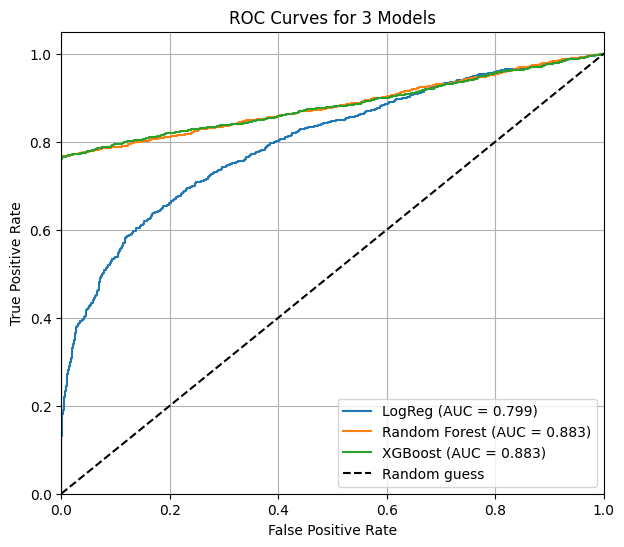

In [27]:
plt.figure(figsize=(7, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f"LogReg (AUC = {roc_auc_lr:.3f})")
plt.plot(fpr_rf,  tpr_rf,  label=f"Random Forest (AUC = {roc_auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {roc_auc_xgb:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Random guess")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for 3 Models")
plt.legend(loc="lower right")
plt.grid(True)

Save Best Model:

In [28]:
feature_names = list(X.columns)
joblib.dump(feature_names, "model_features.pkl")
joblib.dump(xgb, "best_model.pkl")

['best_model.pkl']